In [14]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import fitsio
from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, project_to_multipoles, project_to_wp, utils, setup_logging
from scipy.optimize import curve_fit
from LSS.common_tools import mknz
from astropy.table import Table
import itertools

from dataloc import *
from desiclusteringtools import *

# MAKE ALL PLOTS TEXT BIGGER
plt.rcParams.update({'font.size': 15})
# But legend a bit smaller
plt.rcParams.update({'legend.fontsize': 12})
# Set DPI up a bit
plt.rcParams.update({'figure.dpi': 150})

zmaxes = [0.02595, 0.04067, 0.06336, 0.09792, 0.14977, 0.22620, 0.33694, 0.49523] 
magbins = [-15, -16, -17, -18, -19, -20, -21, -22, -23]
NRAND_SF=[1, 1, 2, 5, 9, 12, 6, 1] 
NRAND_Q=[1, 1, 1, 1, 5, 12, 12, 3] 
NRAND_ALL=[1, 1, 1, 1, 5, 12, 12, 3] 
tracer = "BGS_BRIGHT" 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Results

In [4]:
def get_new_wp(weights, survey, verspec, ver, zmax, nran, njack, region, mag: int, imagingver, quiescent=None, modifiedtracer=True):
    if quiescent:
        folder = f'{np.abs(mag)}-{np.abs(mag)+1}_Q_{imagingver}'
        string = f'_R-{np.abs(mag)}-{np.abs(mag)+1}_Q'
    elif quiescent is None:
        folder = f'{np.abs(mag)}-{np.abs(mag)+1}_ALL_{imagingver}'
        string = f'_R-{np.abs(mag)}-{np.abs(mag)+1}'
    else:
        folder = f'{np.abs(mag)}-{np.abs(mag)+1}_SF_{imagingver}'
        string = f'_R-{np.abs(mag)}-{np.abs(mag)+1}_SF'
        
    if not modifiedtracer:
        string = ''

    dir = os.path.join(CUSTOM_CLUSTERING_RESULTS_FOLDER_NEW, survey, 'LSS', verspec, 'LSScats', ver, folder, 'rppi')

    if not os.path.exists(dir):
        print("WARNING: Directory does not exist: ", dir)
        return None, None
        
    wp_fn = os.path.join(dir, f'wp_BGS_BRIGHT{string}_{region}_0.001_{zmax}_{weights}_custom1_njack{njack}_nran{nran}_split20.txt')

    if not os.path.exists(wp_fn):
        print("WARNING: File does not exist: ", wp_fn)
        return None, None

    try:
        allcounts_fn = os.path.join(dir, f'allcounts_BGS_BRIGHT_{region}_0.001_{zmax}_{weights}_custom_njack{njack}_nran{nran}_split20.npy')
        tpc = TwoPointEstimator.load(allcounts_fn)
        s, xiell, cov = tpc.get_corr(return_sep=True, return_cov=True, mode='wp')
    except Exception as e:
        print("WARNING: Could not load TwoPointEstimator")
        cov = None

    return np.loadtxt(wp_fn), cov

def get_wp_for(tracer, weights, survey, verspec, ver, bins, zmax, nran, njack, region, quiescent=None):
    dir = os.path.join(CUSTOM_CLUSTERING_RESULTS_FOLDER, survey, 'LSS', verspec, 'LSScats', ver, 'rppi')

    if not os.path.exists(dir):
        print("WARNING: Directory does not exist: ", dir)
        return None

    if quiescent is not None:
        addon = '_QUIESCENT' + ('1' if quiescent else '0')
    else:
        addon = ''
        
    wp_fn = os.path.join(dir, f'wp_{tracer}_{region}_0.001_{zmax}_{weights}_{bins}_njack{njack}_nran{nran}_split20{addon}.txt')

    if not os.path.exists(wp_fn):
        print("WARNING: File does not exist: ", wp_fn)
        return None

    return np.loadtxt(wp_fn)

def get_fn_for(weights, survey, verspec, ver, zmax, nran, njack, region, quiescent=None):
    dir = os.path.join(CUSTOM_CLUSTERING_RESULTS_FOLDER, survey, 'LSS', verspec, 'LSScats', ver, 'rppi')

    if not os.path.exists(dir):
        print("WARNING: Directory does not exist: ", dir)
        return None

    if quiescent is not None:
        addon = '_QUIESCENT' + ('1' if quiescent else '0')
    else:
        addon = ''
        
    allcounts_fn = os.path.join(dir, f'allcounts_BGS_BRIGHT_{region}_0.001_{zmax}_{weights}_custom_njack{njack}_nran{nran}_split20{addon}.npy')
    return allcounts_fn


def plot_wp(red_results, blue_results, all_results, zmaxes, magbins):
    plt.figure(figsize=(10, 10))
    for i in range(len(red_results)):
        plt.subplot(3, 3, i+1)
        red_wp, red_cov = red_results[i]
        blue_wp, blue_cov = blue_results[i]
        #all_wp, all_cov = all_results[i]

        plt.xscale('log')
        plt.yscale('log')
        plt.ylim(2, 4000)
        plt.ylabel(r'$w_p(r_p)$')
        plt.xlabel(r'$r_p$ [Mpc/h]')
        plt.title(f'${magbins[i]} > M_r > {magbins[i+1]}$')
        plt.text(0.75, 0.9, f'$z<{zmaxes[i]}$', transform=plt.gca().transAxes, ha='center', va='center', fontsize=10)

        if red_wp is not None:
            if red_wp.shape[1] > 3:
                plt.errorbar(red_wp[:,0], red_wp[:,2], yerr=red_wp[:,3], label=f'Quiescent {zmaxes[i]}', fmt='r.', capsize=3)
            else:
                plt.plot(red_wp[:,0], red_wp[:,2], label=f'Quiescent {zmaxes[i]}', color='r')
        if blue_wp is not None:
            if blue_wp.shape[1] > 3:
                plt.errorbar(blue_wp[:,0], blue_wp[:,2], yerr=blue_wp[:,3], label=f'Star-Forming {zmaxes[i]}', fmt='b.', capsize=3)
            else:
                plt.plot(blue_wp[:,0], blue_wp[:,2], label=f'Star-Forming {zmaxes[i]}', color='b')

    plt.tight_layout()
    plt.show()

## Load results

In [ ]:
red_result_i0 = []
blue_results_i0 = []
all_results_i0 = []
for m, z, rsf, rq in zip(magbins[:-1], zmaxes, NRAND_SF, NRAND_Q):
    for q in [True, False, None]:
        r = rq if q is True else rsf
        wp, cov = get_new_wp('pip_angular_bitwise', 'Y1', 'iron', 'v1.5pip', z, r, 0, 'GCcomb', m, "i0", quiescent=q)
        if q is True:
            red_result_i0.append((wp, cov))
        elif q is False:
            blue_results_i0.append((wp, cov))
        else:
            all_results_i0.append((wp, cov))

In [ ]:
red_results_i1 = []
blue_results_i1 = []
all_results_i1 = []
for m, z, rsf, rq in zip(magbins[:-1], zmaxes, NRAND_SF, NRAND_Q):
    for q in [True, False, None]:
        r = rq if q is True else rsf
        wp, cov = get_new_wp('pip_angular_bitwise', 'Y1', 'iron', 'v1.5pip', z, r, 0, 'GCcomb', m, "i1", quiescent=q)

        if q is True:
            red_results_i1.append((wp, cov))
        elif q is False:
            blue_results_i1.append((wp, cov))
        else:
            all_results_i1.append((wp, cov))




In [ ]:
red_i2_results = []
blue_i2_results = []
all_i2_results = []
for m, z, rsf, rq in zip(magbins[:-1], zmaxes, NRAND_SF, NRAND_Q):
    for q in [True, False, None]:
        r = rq if q is True else rsf
        wp = get_new_wp('pip_bitwise', 'Y1', 'iron', 'v1.5pip', z, r, 0, 'GCcomb', m, "i2", quiescent=q, modifiedtracer=False)

        if q is True:
            red_i2_results.append(wp)
        elif q is False:
            blue_i2_results.append(wp)
        else:
            all_i2_results.append(wp)

In [ ]:
#plot_wp(red_results_i1, blue_results_i1, main_all_results, zmaxes, magbins)

In [ ]:
# Load the equivalent old results from the other NERSC clustering view notebook
# Assuming the old results are stored in a similar directory structure but under CUSTOM_CLUSTERING_RESULTS_FOLDER
#zmaxes = [0.02595, 0.04067, 0.06336, 0.09792, 0.14977, 0.22620, 0.33694, 0.49523] 
#magbins = [-15, -16, -17, -18, -19, -20, -21, -22, -23]
tracer = "BGS_BRIGHT" 
jack_official = 128
old_red_results = []
old_blue_results = []
old_all_results = []
for z, q in itertools.product(zmaxes, [True, False, None]):

    wp = get_wp_for(tracer, 'pip_angular_bitwise', 'Y1', 'iron', 'v1.5pip', 'custom', z, 18, jack_official, 'GCcomb', quiescent=q)
    cov = None
    if wp is not None:
        savedir = get_fn_for('pip_angular_bitwise', 'Y1', 'iron', 'v1.5pip', z, 18, jack_official, 'GCcomb', quiescent=q)
        tpc = TwoPointEstimator.load(savedir)
        s, xiell, cov = tpc.get_corr(return_sep=True, return_cov=True, mode='wp')

    if q is True:
        old_red_results.append((wp, cov))
    elif q is False:
        old_blue_results.append((wp, cov))
    else:
        old_all_results.append((wp, cov))

In [ ]:
def plot_new_vs_old_comparison(i1_results, i0_results, old_results, i2_results, zmaxes, magbins, title_suffix, color='r'):
    """
    Plot comparison between new and old clustering results
    
    Parameters:
    -----------
    new_results : list
        List of (wp, cov) tuples for new results
    new_i0_results : list  
        List of (wp, cov) tuples for new i0 results
    old_results : list
        List of (wp, cov) tuples for old results
    zmaxes : list
        Redshift limits for each magnitude bin
    magbins : list
        Magnitude bin edges
    title_suffix : str
        Suffix to add to plot title (e.g., "Red Galaxies", "Blue Galaxies")
    color : str
        Color for new results plots
    """

    # assert all lengths are the same
    assert len(i1_results) == len(old_results) == len(i0_results) == len(i2_results)

    plt.figure(figsize=(11, 11))
    for i in range(len(old_results)):
        plt.subplot(3, 3, i+1)
        i1, _ = i1_results[i] if i1_results else (None, None)
        i0, _ = i0_results[i] if i0_results else (None, None)
        old_wp, _ = old_results[i]
        i2, _ = i2_results[i] if i2_results else (None, None)
        #noang, _ = noangular[i] if noangular else (None, None)

        plt.xscale('log')
        plt.yscale('log')
        plt.ylim(1, 4000)
        plt.ylabel(r'$w_p(r_p)$')
        plt.xlabel(r'$r_p$ [Mpc/h]')
        plt.title(f'${magbins[i]} > M_r > {magbins[i+1]}$')
        plt.text(0.2, 0.1, f'$z<{zmaxes[i]}$', transform=plt.gca().transAxes, ha='center', va='center', fontsize=10)

        if old_wp is not None:
            if old_wp.shape[1] > 3:
                plt.errorbar(old_wp[:,0], old_wp[:,2], yerr=old_wp[:,3], label='Old ang', fmt='k.', capsize=3)
            else:
                plt.plot(old_wp[:,0], old_wp[:,2], label='Old ang', color='k')
        
        if i1 is not None:
            if i1.shape[1] > 3:
                plt.errorbar(i1[:,0], i1[:,2], yerr=i1[:,3], label='ang i1', fmt=f'{color}.', capsize=3, alpha=0.7)
            else:
                plt.plot(i1[:,0], i1[:,2], label='ang i1', color=color, alpha=0.7)
        
        if i0 is not None:
            if i0.shape[1] > 3:
                plt.errorbar(i0[:,0], i0[:,2], yerr=i0[:,3], label='ang i0', fmt=f'purple--', capsize=3)
            else:
                plt.plot(i0[:,0], i0[:,2], label='ang i0', color='purple', linestyle='--')   

        if i2 is not None:
            if i2.shape[1] > 3:
                plt.errorbar(i2[:,0], i2[:,2], yerr=i2[:,3], label='3p i1', fmt='g:', capsize=3)
            else:
                plt.plot(i2[:,0], i2[:,2], label='3p i1', color='g', linestyle=':')

        plt.legend()

    plt.suptitle(f'Clustering Comparison - {title_suffix}')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_new_vs_old_comparison_pct(i1_results, i0_results, old_results, i2_results, zmaxes, magbins, title_suffix, color='r'):
    """
    Plot percent difference between new and old clustering results.

    Shows: 100 * (new - old) / old for each bin.

    Parameters:
    -----------
    i1_results : list
        List of (wp, cov) tuples for new i1 results
    i0_results : list  
        List of (wp, cov) tuples for new i0 results
    old_results : list
        List of (wp, cov) tuples for old results
    i2_results : list
        List of (wp, cov) tuples for i2 results
    zmaxes : list
        Redshift limits for each magnitude bin
    magbins : list
        Magnitude bin edges
    title_suffix : str
        Suffix to add to plot title (e.g., "Red Galaxies", "Blue Galaxies")
    color : str
        Color for new results plots
    """
    assert len(i1_results) == len(old_results) == len(i0_results) == len(i2_results)

    plt.figure(figsize=(11, 11))
    for i in range(len(old_results)):
        plt.subplot(3, 3, i+1)
        i1, _ = i1_results[i] if i1_results else (None, None)
        i0, _ = i0_results[i] if i0_results else (None, None)
        old_wp, _ = old_results[i]
        i2, _ = i2_results[i] if i2_results else (None, None)

        plt.xscale('log')
        plt.axhline(0, color='gray', linestyle='--', lw=1)
        plt.ylabel(r'$\Delta w_p / w_p^\mathrm{old}$ [%]')
        plt.xlabel(r'$r_p$ [Mpc/h]')
        plt.title(f'${magbins[i]} > M_r > {magbins[i+1]}$')
        plt.text(0.2, 0.1, f'$z<{zmaxes[i]}$', transform=plt.gca().transAxes, ha='center', va='center', fontsize=10)

        if old_wp is not None and old_wp.shape[1] > 2:
            x = old_wp[:,0]
            y_old = old_wp[:,2]
            yerr_old = old_wp[:,3] if old_wp.shape[1] > 3 else None

            # i1
            if i1 is not None and i1.shape[1] > 2:
                y_i1 = i1[:,2]
                pct_diff = 100 * (y_i1 - y_old) / y_old
                plt.plot(x, pct_diff, f'{color}-', label='i1 vs old', alpha=0.7)
            # i0
            if i0 is not None and i0.shape[1] > 2:
                y_i0 = i0[:,2]
                pct_diff = 100 * (y_i0 - y_old) / y_old
                plt.plot(x, pct_diff, 'purple--', label='i0 vs old')
            # i2
            if i2 is not None and i2.shape[1] > 2:
                y_i2 = i2[:,2]
                pct_diff = 100 * (y_i2 - y_old) / y_old
                plt.plot(x, pct_diff, 'g:', label='i2 vs old')

        plt.legend()

    plt.suptitle(f'Percent Difference: New vs Old - {title_suffix}')
    plt.tight_layout()
    plt.show()

# wp plots

In [ ]:
# Overlay new vs old results for red galaxies
plot_new_vs_old_comparison(red_results_i1, red_result_i0, old_red_results, red_i2_results,
                          zmaxes, magbins, "Quiescent", color='r')

In [ ]:
# Overlay new vs old results for blue galaxies  
plot_new_vs_old_comparison(blue_results_i1, blue_results_i0, old_blue_results, blue_i2_results,
                          zmaxes, magbins, "Star-Forming", color='b')

In [ ]:
# Overlay new vs old results for all galaxies  
plot_new_vs_old_comparison(all_results_i1, all_results_i0, old_all_results, all_i2_results,
                          zmaxes, magbins, "All", color='m')

# Test of NRADJACK

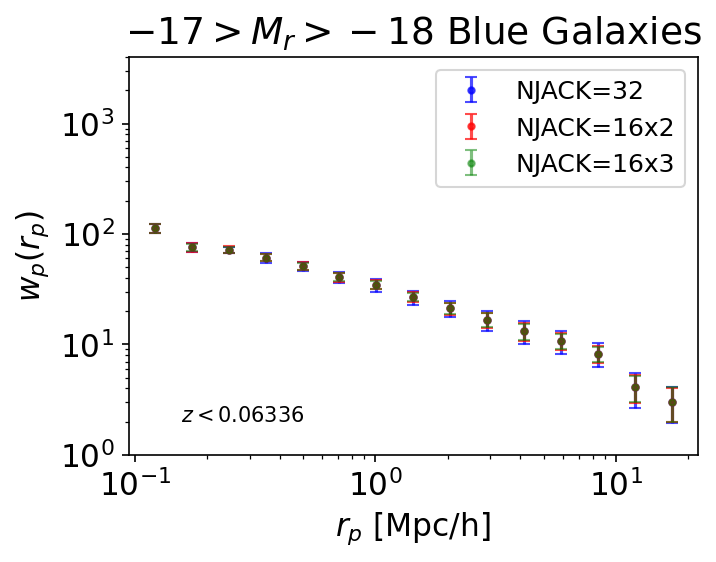

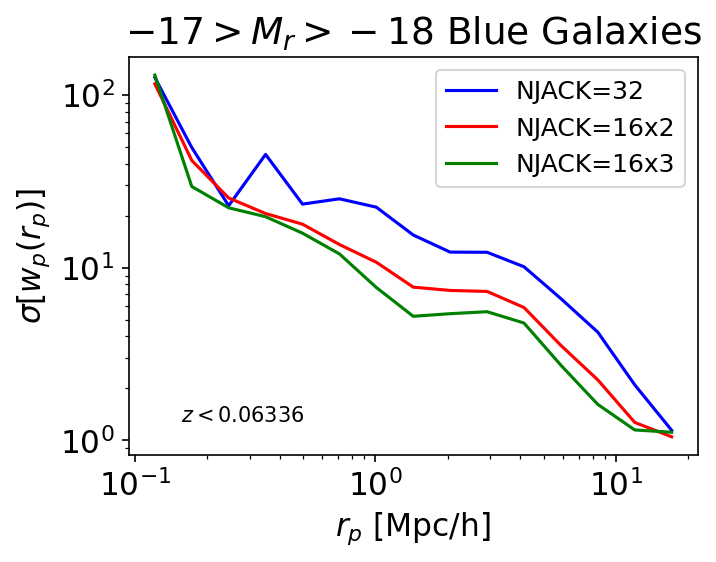

In [13]:
z = zmaxes[2]
m = magbins[2]
q = False
nran = 2
normal_wp, normal_cov = get_new_wp('pip_bitwise', 'Y1', 'iron', 'v1.5pip', z, nran, 32, 'GCcomb', m, "i2", quiescent=q, modifiedtracer=False) 
zjack_wp, zjack_cov = get_new_wp('pip_bitwise', 'Y1', 'iron', 'v1.5pip', z, nran, '16x2', 'GCcomb', m, "i2", quiescent=q, modifiedtracer=False) 
zjack3_wp, zjack3_cov = get_new_wp('pip_bitwise', 'Y1', 'iron', 'v1.5pip', z, nran, '16x3', 'GCcomb', m, "i2", quiescent=q, modifiedtracer=False) 

# Compare normal 64 jackknife vs 64x2 radial jackknife
plt.figure(figsize=(5, 4))
plt.xscale('log')
plt.yscale('log')
plt.ylim(1, 4000)
plt.ylabel(r'$w_p(r_p)$')
plt.xlabel(r'$r_p$ [Mpc/h]')
plt.title(f'${m} > M_r > {magbins[3]}$ Blue Galaxies')
plt.text(0.2, 0.1, f'$z<{z}$', transform=plt.gca().transAxes, ha='center', va='center', fontsize=10)

if normal_wp is not None:
    if normal_wp.shape[1] > 3:
        plt.errorbar(normal_wp[:,0], normal_wp[:,2], yerr=normal_wp[:,3], label=f'NJACK=32', fmt='b.', capsize=3, alpha=0.7)
    else:
        plt.plot(normal_wp[:,0], normal_wp[:,2], label=f'NJACK=32', color='b', alpha=0.7)
if zjack_wp is not None:
    if zjack_wp.shape[1] > 3:
        plt.errorbar(zjack_wp[:,0], zjack_wp[:,2], yerr=zjack_wp[:,3], label=f'NJACK=16x2', fmt='r.', capsize=3, alpha=0.7)
    else:
        plt.plot(zjack_wp[:,0], zjack_wp[:,2], label=f'NJACK=16x2', color='r', alpha=0.7)
if zjack3_wp is not None:
    if zjack3_wp.shape[1] > 3:
        plt.errorbar(zjack3_wp[:,0], zjack3_wp[:,2], yerr=zjack3_wp[:,3], label=f'NJACK=16x3', fmt='g.', capsize=3, alpha=0.5)
    else:
        plt.plot(zjack3_wp[:,0], zjack3_wp[:,2], label=f'NJACK=16x3', color='g', alpha=0.5)

plt.legend()
plt.tight_layout()
plt.show()

# Plot the error bars only
plt.figure(figsize=(5, 4))
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\sigma[w_p(r_p)]$')
plt.xlabel(r'$r_p$ [Mpc/h]')
plt.title(f'${m} > M_r > {magbins[3]}$ Blue Galaxies')
plt.text(0.2, 0.1, f'$z<{z}$', transform=plt.gca().transAxes, ha='center', va='center', fontsize=10)
plt.plot(normal_wp[:,0], np.diag(normal_cov), label='NJACK=32', color='b', alpha=1.0)
plt.plot(zjack_wp[:,0], np.diag(zjack_cov), label='NJACK=16x2', color='r', alpha=1.0)
plt.plot(zjack3_wp[:,0], np.diag(zjack3_cov), label='NJACK=16x3', color='g', alpha=1.0)
plt.legend()
plt.tight_layout()
plt.show()


# Testing ndens covariance

In [ ]:
def plot_corr_matrix_for_wppi(cov, r):
    """
    Plots a correlation coefficient matrix from a covariance matrix.
    If cov is (N+1, N+1) and len(r) == N, assumes last row/col is number density.
    """
    n = len(r)
    if cov.shape[0] == n + 1 and cov.shape[1] == n + 1:
        # Separate out the number density row/col
        corrmatrix = utils.cov_to_corrcoef(cov)
        labels = [f"{val:.2f}" for val in r] + ['ndens']
    else:
        corrmatrix = utils.cov_to_corrcoef(cov)
        labels = [f"{val:.2f}" for val in r]

    plt.figure(figsize=(7, 6))
    from matplotlib.colors import Normalize
    norm = Normalize(vmin=-1, vmax=1)
    plt.pcolor(corrmatrix, cmap='viridis', norm=norm)
    plt.colorbar()
    plt.title('Correlation matrix')
    plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=90)
    plt.yticks(ticks=np.arange(len(labels)), labels=labels)
    plt.xlabel(r'$s$ [$h^{-1}$ Mpc]' + (', ndens' if len(labels) > n else ''))
    plt.ylabel(r'$s$ [$h^{-1}$ Mpc]' + (', ndens' if len(labels) > n else ''))
    plt.tight_layout()
    plt.show()

In [ ]:
base = '/global/cfs/cdirs/desi/users/ianw89/newclustering/Y1/LSS/iron/LSScats/v1.5pip/21-22_ALL_i1/'

estimator = TwoPointEstimator.load(base + '/smu/allcounts_BGS_BRIGHT_R-21-22_ALL_NGC_0.001_0.06336_pip_bitwise_log_njack16x2_nran2_split20.npy')
dens_reals = np.load(base + '/smu/ndens_BGS_BRIGHT_R-21-22_ALL_NGC_0.001_0.06336_pip_bitwise_log_njack16x2_nran2_split20.npy')


In [ ]:
from LSS.common_tools import get_cov_with_ndens
s, sells, cov = get_cov_with_ndens(estimator, dens_reals, ells=(0,), ignore_nan=True)
corrmatrix = plot_corr_matrix_for_smu(cov, s, len(sells))

# Comparisons

In [ ]:
def get_FSF(indata,fsf_cols,fsf_dir='/pscratch/sd/i/ioannis/fastspecfit/data/loa/catalogs/',prog='bright'):
    from astropy.table import Table,join
    fsl = []
    for hp in range(0,12):
        fsi = fitsio.read(fsf_dir+f'fastspec-iron-main-{prog}-nside1-hp'+str(hp).zfill(2)+'.fits',ext='SPECPHOT',columns = fsf_cols)
        fsl.append(fsi)
    fs = np.concatenate(fsl)
    del fsl
    ol = len(indata)
    # Print fs columns names
    indata = join(indata,fs,keys=['TARGETID']) #note, anything missing from fastspecfit will now be missing
    del fs
    return indata
    

In [ ]:
# Look at the prepared data
dirorig = os.path.join('/dvs_ro/cfs/cdirs/desi/survey/catalogs/', 'Y1', 'LSS', 'iron', 'LSScats', 'v1.5pip')
dirold = os.path.join(CUSTOM_CLUSTERING_RESULTS_FOLDER, 'Y1', 'LSS', 'iron', 'LSScats', 'v1.5pip')
diri0 = os.path.join(CUSTOM_CLUSTERING_RESULTS_FOLDER_NEW, 'Y1', 'LSS', 'iron', 'LSScats', 'v1.5pip', '19-20_SF_i0')
diri0_fixed = os.path.join(CUSTOM_CLUSTERING_RESULTS_FOLDER_NEW, 'Y1', 'LSS', 'iron', 'LSScats', 'v1.5pip', '19-20_SF_i0angfixed')
tbl1 = Table(fitsio.read(os.path.join(dirorig, 'BGS_BRIGHT_NGC_clustering.dat.fits')))
tbl2 = Table(fitsio.read(os.path.join(dirold, 'BGS_BRIGHT_NGC_clustering.dat.fits')))
tbl3 = Table(fitsio.read(os.path.join(diri0, 'BGS_BRIGHT_NGC_clustering.dat.fits')))
tbl4 = Table(fitsio.read(os.path.join(diri0_fixed, 'BGS_BRIGHT_R-19-20_SF_NGC_clustering.dat.fits')))

In [ ]:
#tbl1 = get_FSF(tbl1, ['TARGETID', 'ABSMAG01_SDSS_R'], fsf_dir='/global/cfs/cdirs/desi/public/dr1/vac/dr1/fastspecfit/iron/v3.0/catalogs/', prog='bright')
tbl3 = get_FSF(tbl3, ['TARGETID', 'ABSMAG01_SDSS_R'], fsf_dir='/global/cfs/cdirs/desi/public/dr1/vac/dr1/fastspecfit/iron/v3.0/catalogs/', prog='bright')

In [ ]:
import pandas as pd
# It appears with new method i0 vs i1 does not matter
# BUT Old method vs this is totally different
df_orig = tbl1
df_old = tbl2
df_new = tbl3
df_i0_fixed = tbl4

# Drop BITWEIGHT column and convert to pandas
# Only keep columns in df_orig that are in df_old or df_new
if 'BITWEIGHTS' in df_orig.columns:
    df_orig.remove_columns(['BITWEIGHTS'])
if 'BITWEIGHTS' in df_old.columns:
    df_old.remove_columns(['BITWEIGHTS'])
if 'BITWEIGHTS' in df_new.columns:
    df_new.remove_columns(['BITWEIGHTS'])
if 'BITWEIGHTS' in df_i0_fixed.columns:
    df_i0_fixed.remove_columns(['BITWEIGHTS'])

df_orig: pd.DataFrame = df_orig.to_pandas()
df_old: pd.DataFrame = df_old.to_pandas()
df_new: pd.DataFrame = df_new.to_pandas()
df_i0_fixed: pd.DataFrame = df_i0_fixed.to_pandas()
df_orig.set_index('TARGETID', inplace=True)
df_old.set_index('TARGETID', inplace=True)
df_new.set_index('TARGETID', inplace=True)
df_i0_fixed.set_index('TARGETID', inplace=True)

In [ ]:
# filter them to same z and abs mag range
# 0.001 < z < 0.14977
# -20 < M_r < -19
df_orig = df_orig.loc[(df_orig['Z'] > 0.001) & (df_orig['Z'] < 0.14977)]
df_old = df_old.loc[(df_old['Z'] > 0.001) & (df_old['Z'] < 0.14977)]
df_new = df_new.loc[(df_new['Z'] > 0.001) & (df_new['Z'] < 0.14977)]
df_i0_fixed = df_i0_fixed.loc[(df_i0_fixed['Z'] > 0.001) & (df_i0_fixed['Z'] < 0.14977)]

In [ ]:
# Compare df_old and df_new in several ways

# 1. Print basic info
print("df_orig: rows =", len(df_orig), "columns =", len(df_orig.columns))
print("df_old: rows =", len(df_old), "columns =", len(df_old.columns))
print("df_new: rows =", len(df_new), "columns =", len(df_new.columns))
print("df_new_i1: rows =", len(df_i0_fixed), "columns =", len(df_i0_fixed.columns))

# 2. Find columns in one but not the other
print("\nColumns in df_old but not df_new:", set(df_old.columns) - set(df_new.columns))
print("Columns in df_new but not df_old:", set(df_new.columns) - set(df_old.columns))

# 3. Compare summary statistics for columns in common
common_cols = set(df_old.columns) & set(df_new.columns)
for col in common_cols:
    if df_old[col].dtype.kind in 'if' and df_new[col].dtype.kind in 'if':
        print(f"\nColumn: {col}")
        print("  df_old: mean =", df_old[col].mean(), "std =", df_old[col].std())
        print("  df_new: mean =", df_new[col].mean(), "std =", df_new[col].std())

In [ ]:
# Create temporary dataframes with just the columns we need
df_orig_temp = df_orig.reset_index()[['TARGETID', 'WEIGHT', 'WEIGHT_COMP', 'WEIGHT_SYS', 'WEIGHT_ZFAIL', 'WEIGHT_FKP']].copy()
df_old_temp = df_old.reset_index()[['TARGETID', 'WEIGHT', 'WEIGHT_COMP', 'WEIGHT_SYS', 'WEIGHT_ZFAIL', 'WEIGHT_FKP']].copy()
df_new_temp = df_new.reset_index()[['TARGETID', 'WEIGHT', 'WEIGHT_COMP', 'WEIGHT_SYS', 'WEIGHT_ZFAIL', 'WEIGHT_FKP']].copy()
df_i0_fixed_temp = df_i0_fixed.reset_index()[['TARGETID', 'WEIGHT', 'WEIGHT_COMP', 'WEIGHT_SYS', 'WEIGHT_ZFAIL', 'WEIGHT_FKP']].copy()

# Merge on TARGETID
merged_df = df_old_temp.merge(df_new_temp, on='TARGETID', suffixes=('_old', '_new'))
merged_df = merged_df.merge(df_orig_temp, on='TARGETID', suffixes=('', '_orig'))
merged_df = merged_df.merge(df_i0_fixed_temp, on='TARGETID', suffixes=('', '_new_i1'))
print(f"Successfully merged {len(merged_df)} rows")


In [ ]:
# Take some TARGETIDs from df_new and print off the ABSMAG_R from the match in old
print("TARGETID: New (WEIGHT) vs Old (WEIGHT) vs Orig (WEIGHT)")
sample_ids = pd.Index(df_new.index).intersection(df_old.index)
if len(sample_ids) > 0:
    target_ids = np.random.choice(sample_ids, size=min(10, len(sample_ids)), replace=False)
    for target_id in target_ids:
        new_row = df_new.loc[[target_id]]
        old_row = df_old.loc[[target_id]]
        orig_row = df_orig.loc[[target_id]]
        print(f"{target_id}: {new_row['WEIGHT'].values[0]:.5f} vs {old_row['WEIGHT'].values[0]:.5f} vs {orig_row['WEIGHT'].values[0]:.5f}")


In [ ]:
# Calculate percent change in all WEIGHT* columns from ORIG to OLD and ORIG to NEW
weight_cols = ['WEIGHT', 'WEIGHT_COMP', 'WEIGHT_SYS', 'WEIGHT_ZFAIL', 'WEIGHT_FKP']

for col in weight_cols:
    merged_df[f'{col.lower()}_diff_pct_orig_to_old'] = 100 * (merged_df[f'{col}_old'] - merged_df[col]) / merged_df[col]
    merged_df[f'{col.lower()}_diff_pct_orig_to_new_i0'] = 100 * (merged_df[f'{col}_new'] - merged_df[col]) / merged_df[col]
    merged_df[f'{col.lower()}_diff_pct_orig_to_new_i1'] = 100 * (merged_df[f'{col}_new_i1'] - merged_df[col]) / merged_df[col]

for col in weight_cols:
    print(f"\nSummary of {col} percent change (ORIG to OLD):")
    print(f"Mean: {merged_df[f'{col.lower()}_diff_pct_orig_to_old'].mean():.3f}%, Median: {merged_df[f'{col.lower()}_diff_pct_orig_to_old'].median():.3f}%, Std: {merged_df[f'{col.lower()}_diff_pct_orig_to_old'].std():.3f}%")
    print(f"Summary of {col} percent change (ORIG to i0):")
    print(f"Mean: {merged_df[f'{col.lower()}_diff_pct_orig_to_new_i0'].mean():.3f}%, Median: {merged_df[f'{col.lower()}_diff_pct_orig_to_new_i0'].median():.3f}%, Std: {merged_df[f'{col.lower()}_diff_pct_orig_to_new_i0'].std():.3f}%")
    print(f"Summary of {col} percent change (ORIG to i0 fixed):")
    print(f"Mean: {merged_df[f'{col.lower()}_diff_pct_orig_to_new_i1'].mean():.3f}%, Median: {merged_df[f'{col.lower()}_diff_pct_orig_to_new_i1'].median():.3f}%, Std: {merged_df[f'{col.lower()}_diff_pct_orig_to_new_i1'].std():.3f}%")

In [ ]:
# Calculate differences
merged_df['weight_diff_pct'] = 100 * (merged_df['WEIGHT_new'] - merged_df['WEIGHT_old']) / merged_df['WEIGHT_old']
merged_df['absmag_diff_pct'] = 100 * (merged_df['ABSMAG01_SDSS_R'] - merged_df['ABSMAG_R']) / merged_df['ABSMAG_R']

# Print summary statistics
print(f"\nMerged dataframe statistics:")
print(f"Weight differences - Mean: {merged_df['weight_diff_pct'].mean():.3f}%, Median: {merged_df['weight_diff_pct'].median():.3f}%, Std: {merged_df['weight_diff_pct'].std():.3f}%")
print(f"AbsMag differences - Mean: {merged_df['absmag_diff_pct'].mean():.3f}%, Median: {merged_df['absmag_diff_pct'].median():.3f}%, Std: {merged_df['absmag_diff_pct'].std():.3f}%")

# Check for extreme outliers
extreme_weight_outliers = np.abs(merged_df['weight_diff_pct']) > 100
print(f"\nNumber of extreme weight outliers (>100% difference): {extreme_weight_outliers.sum()}")

if extreme_weight_outliers.sum() > 0:
    print("Examples of extreme weight outliers:")
    outlier_examples = merged_df[extreme_weight_outliers].head(5)
    for _, row in outlier_examples.iterrows():
        print(f"  TARGETID {row['TARGETID']}: Old weight {row['WEIGHT_old']:.3f}, New weight {row['WEIGHT_new']:.3f}, Diff: {row['weight_diff_pct']:.1f}%")

# Show random sample from merged data
print(f"\nRandom sample from merged data:")
sample_merged = merged_df.sample(min(10, len(merged_df)))
for _, row in sample_merged.iterrows():
    print(f"TARGETID {row['TARGETID']}: Weight diff: {row['weight_diff_pct']:.1f}%, AbsMag diff: {row['absmag_diff_pct']:.1f}%")

# View Imaging Systematics

In [ ]:
fn = f'BGS_BRIGHT_R-19-20_SF_clustering.dat.fits'
path = os.path.join(CUSTOM_CLUSTERING_RESULTS_FOLDER_NEW, 'Y1', 'LSS', 'iron', 'LSScats', 'v1.5pip', '19-20_SF_i1', fn)
tbl = Table(fitsio.read(path))
print(tbl.colnames)
junk=plt.hist(tbl['WEIGHT_SYS'], bins=100, range=(0.5,1.5))

In [ ]:
for mag in magbins[:-1]: 
    for q in ['Q', 'SF']:
        for region in ['N', 'S']:
            fn = f'BGS_BRIGHT_R-{abs(mag)}-{abs(mag)+1}_{q}_{region}_0.0010.5_linclusimsysfit.png'
            path = os.path.join(CUSTOM_CLUSTERING_RESULTS_FOLDER_NEW, 'Y1', 'LSS', 'iron', 'LSScats', 'v1.5pip', f'{abs(mag)}-{abs(mag)+1}_{q}_i1', fn)
            if os.path.exists(path):
                plt.figure(figsize=(10, 10))
                img = plt.imread(path)
                plt.imshow(img)
                plt.axis('off') 
                plt.title(f'{abs(mag)}-{abs(mag)+1}mag {q} Imaging Sys Fit ({region})')
                plt.show()
                
                # Also print off the .txt file. Same thing but _linfitparam.txt
                if (False):
                    txt_fn = path.replace('_linclusimsysfit.png', '_linfitparam.txt')
                    if os.path.exists(txt_fn):
                        with open(txt_fn, 'r') as f:
                            print(f.read())
                    else:
                        print("No text file found for", txt_fn)

            # Load catalog and compare imaging systematics to old ones
            fn = f'BGS_BRIGHT_R-{abs(mag)}-{abs(mag)+1}_{q}_{region}GC_clustering.dat.fits'
            path = os.path.join(CUSTOM_CLUSTERING_RESULTS_FOLDER_NEW, 'Y1', 'LSS', 'iron', 'LSScats', 'v1.5pip', f'{abs(mag)}-{abs(mag)+1}_{q}_i1', fn)
            if os.path.exists(path):
                tbl = Table(fitsio.read(path))
                tbl.remove_column('BITWEIGHTS')
                tbl = tbl.to_pandas()
                print(f"Loaded catalog {abs(mag)}-{abs(mag)+1} {q} {region}GC")
                tbl['SYS_CHANGE'] = (tbl['WEIGHT_SYS_OLD'] - tbl['WEIGHT_SYS']) * 100 / tbl['WEIGHT_SYS']
                plt.figure(figsize=(10, 5))
                plt.hist(tbl['WEIGHT_SYS_OLD'], bins=100, alpha=0.5, label='Old WEIGHT_SYS', range=(0.5, 1.5))
                plt.hist(tbl['WEIGHT_SYS'], bins=100, alpha=0.5, label='New WEIGHT_SYS', range=(0.5, 1.5))
                plt.yscale('log')
                plt.xlabel('Weight')
                plt.ylabel('Count')
                plt.title(f'Weight Distribution: {abs(mag)}-{abs(mag)+1} {q} {region}GC')
                plt.legend()
                plt.show()



In [ ]:
import re
re.sub(r'_[A-Z]-[0-9]+-[0-9]+_[a-zA-Z]+_', '_', 'BGS_BRIGHT_R-19-20_Q_full_HPmapcut.dat.fits')

# Save

In [ ]:
save_wp(PARAMS_BGSY1_FOLDER, red_results_i1, blue_results_i1, all_results_i1, magbins)

In [20]:
foo

[1, 2, 3, 4, 5, 6, 7, 8, 9]